In [1]:
import pygplates
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../../passive_margins')
sys.path.append('../../atom_utils')
sys.path.append('../../GPlatesClassStruggle')

from pigplates import sphere_tools as pigsph

#import PlateFrameRasters

%matplotlib inline
%load_ext autoreload
%autoreload 2

from Package_ReconstructScalarCoverages import group_points_by_plate_id, reconstruct_point_groups

from raster_reconstruction_classes import *


rotation_filename = '/Users/Simon/GIT/gplates-web-service/django/GWS/DATA/MODELS/SETON2012/Seton_etal_ESR2012_2012.1.rot'

static_polygon_filename = '/Users/Simon/GIT/gplates-web-service/django/GWS/DATA/MODELS/SETON2012/Seton_etal_ESR2012_ContinentalPolygons_2012.1.gpmlz'

paleotopography_grid = '../published/Herold/herold_etal_eocene_topo_1x1.nc'


static_polygon_features = pygplates.FeatureCollection(static_polygon_filename)
rotation_model = pygplates.RotationModel(rotation_filename)


Find static polygons...
Group by polygons...
Find static polygons...
Group by polygons...


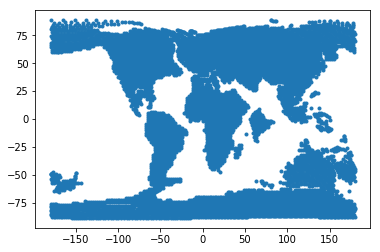

In [11]:
tmpX,tmpY = np.meshgrid(np.arange(-180.,180.01,2.),np.arange(-90.,90.01,2.)) 
tmpX = tmpX.flatten()
tmpY = tmpY.flatten()

clip_points = [pygplates.PointOnSphere(point) for point in zip(tmpY,tmpX)]

#points,data_array = xyzfile_to_spatial_tree_of_points(ascii_grid_file)
#spatial_tree_of_uniform_recon_points = points_spatial_tree.PointsSpatialTree(points)

points_grouped_by_plate_id = group_points_by_plate_id(clip_points,static_polygon_features)

clip_points2 = []
for plate_id, point_indices in points_grouped_by_plate_id.iteritems():
    if plate_id!=0:
        points_in_plate = [clip_points[point_index] for point_index in point_indices]
        clip_points2.extend(points_in_plate)

points_grouped_by_plate_id = group_points_by_plate_id(clip_points2,static_polygon_features)

recon_point_lons,recon_point_lats = reconstruct_point_groups(clip_points2,
                                                             points_grouped_by_plate_id,
                                                             rotation_model,
                                                             55.,
                                                             anchor_plate_id=0)

plt.plot(recon_point_lons,recon_point_lats,'.')



7711 7711


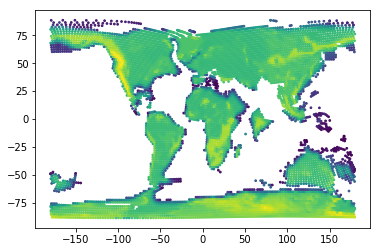

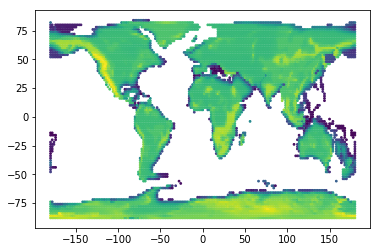

In [12]:
ptopo = GplatesRaster(paleotopography_grid, z_field_name='topo')

ptopo_pts = ptopo.sample(recon_point_lons,recon_point_lats)

print len(ptopo_pts), len(recon_point_lons)

#print clip_points2[0].to_lat_lon()

cl_lon = [point.to_lat_lon()[1] for point in clip_points2]
cl_lat = [point.to_lat_lon()[0] for point in clip_points2]
plt.scatter(recon_point_lons,recon_point_lats,
            c=ptopo_pts,s=3)
plt.show()

plt.scatter(cl_lon,cl_lat,
            c=ptopo_pts,s=3)
plt.show()


Reconstruct static polygons...
Find static polygons...
Group by polygons...
Reverse reconstruct points...
Sample present-day grid...


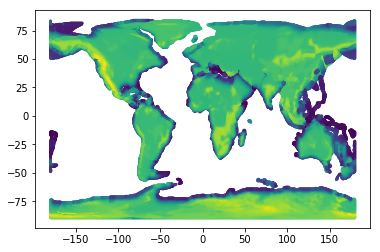

In [19]:
import points_spatial_tree
from reconstruct_atom_rasters import *

tmpX,tmpY = np.meshgrid(np.arange(-180.,180.01,0.5),np.arange(-90.,90.01,0.5)) 
tmpX = tmpX.flatten()
tmpY = tmpY.flatten()

clip_points = [pygplates.PointOnSphere(point) for point in zip(tmpY,tmpX)]

spatial_tree_of_uniform_recon_points = points_spatial_tree.PointsSpatialTree(clip_points)

(recon_point_lons,
 recon_point_lats,
 point_lons,
 point_lats) = reconstruct_raster_stage(static_polygon_features,
                                        rotation_model,
                                        55.,
                                        0.,
                                        clip_points,
                                        spatial_tree_of_uniform_recon_points)

#plt.figure(figsize=(20,10))
#plt.plot(point_lons,point_lats,'.')
#plt.show()

#plt.figure(figsize=(20,10))
#plt.plot(recon_point_lons,recon_point_lats,'.')
#plt.show()

ptopo_pts = ptopo.sample(point_lons,point_lats)

plt.scatter(recon_point_lons,recon_point_lats,
            c=ptopo_pts,s=3)
plt.show()
